# Introduction

Url project: https://www.kaggle.com/competitions/us-patent-phrase-to-phrase-matching/overview

**Objective**: apply an statistical analysis and test different models to get the best score.

**Conditions**:

* There are two sources: train.csv and test.csv.
* The data is observational, no experimental, so I can only find correlation, no causation.
* I do not know what method to collect data was used, so I assume that this data was collected using simple random sample, and each observation is independent each other.
* Words are in English.

Libraries:

* Python: 3.7
* Pandas: 1.3.5
* Numpy: 1.21.6
* sklearn: 1.0.2

# Prepare environment

In [ ]:
!pip install kaggle --upgrade --force

In [ ]:
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 68 bytes


In [ ]:
!kaggle competitions download -c us-patent-phrase-to-phrase-matching

  0% 0.00/682k [00:00<?, ?B/s]
100% 682k/682k [00:00<00:00, 78.4MB/s]


In [ ]:
!unzip us-patent-phrase-to-phrase-matching.zip

Archive:  us-patent-phrase-to-phrase-matching.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


## Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
import string
import re
from dataclasses import dataclass

import sklearn
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.decomposition import PCA

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import gensim
import gensim.downloader

In [ ]:
PATH_DATA = '/content/'
SEED = 1
TOTAL_CLASS = 0

In [ ]:
np.random.seed(SEED)

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Data explanatory analysis

## Train data

Data for training.

Predictor variable:

* **id**: unique variable.
* **anchor**: categorical regular variable.
* **target**: categorical regular variable.
* **context**: categorical regular variable.

Target variable:

* **score**: categorical ordinal variable.

In [ ]:
dsTrain = pd.read_csv(os.path.join(PATH_DATA, 'train.csv'))
print('Shape:', dsTrain.shape)
dsTrain.head()

Shape: (36473, 5)


,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


In [ ]:
dsTrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36473 entries, 0 to 36472
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       36473 non-null  object 
 1   anchor   36473 non-null  object 
 2   target   36473 non-null  object 
 3   context  36473 non-null  object 
 4   score    36473 non-null  float64
dtypes: float64(1), object(4)
memory usage: 1.4+ MB


In [ ]:
print('Number of unique values for anchor variable:', len(dsTrain['anchor'].unique()))
print('Number of unique values for target variable:', len(dsTrain['target'].unique()))
print('Number of unique values for context variable:', len(dsTrain['context'].unique()))
print('Number of unique values for score variable:', len(dsTrain['score'].unique()))

Number of unique values for anchor variable: 733
Number of unique values for target variable: 29340
Number of unique values for context variable: 106
Number of unique values for score variable: 5


In [ ]:
TOTAL_CLASS = len(dsTrain['score'].unique())

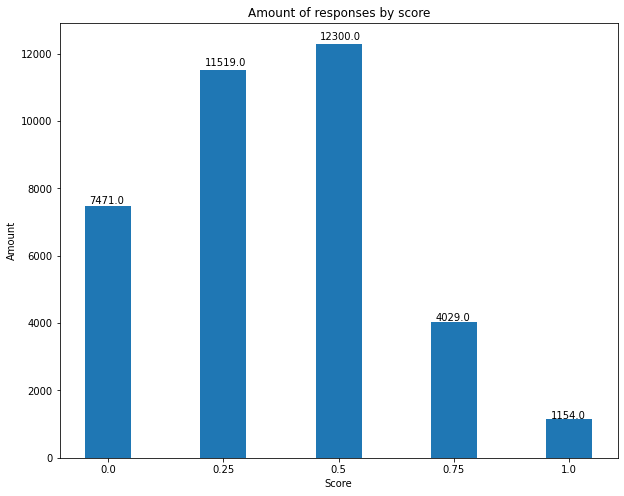

In [ ]:
ar1 = dsTrain[['id', 'score']].groupby('score').count().reset_index().values

plt.figure(figsize = (10, 8))
plt.bar(ar1[:, 0], ar1[:, 1], width = 0.1)
plt.xticks(ar1[:, 0], labels = [0.00, 0.25, 0.50, 0.75, 1.00])

for i in range(ar1.shape[0]):
    plt.text(ar1[i][0] - 0.04, ar1[i][1] + ar1[i][1] * 0.01, str(ar1[i][1]))

plt.title('Amount of responses by score')
plt.xlabel('Score')
plt.ylabel('Amount')
plt.show()

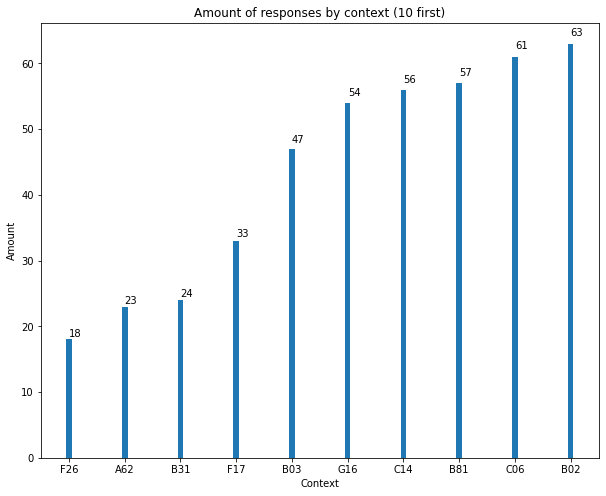

In [ ]:
ar1 = dsTrain[['id', 'context']].groupby('context').count().reset_index().rename(columns = { 'id': 'count' })
ar1 = ar1.sort_values(by = ['count']).head(10).values

plt.figure(figsize = (10, 8))
plt.bar(ar1[:, 0], ar1[:, 1], width = 0.1)

for i in range(ar1.shape[0]):
    plt.text(ar1[i][0], ar1[i][1] + ar1[i][1] * 0.02, str(ar1[i][1]))

plt.title('Amount of responses by context (10 first)')
plt.xlabel('Context')
plt.ylabel('Amount')
plt.show()

##### Conclusions

* There is no null data.
* It is a multiclass problem.
* anchor and target have many unique values, so apply one-hot-encoding is not a good option due to there would be many predictor variables. I need dense vectors.
* context has also many unique values, but in this case I will remove letters and treat it as number. Only for simplicity.

### Clean data

#### Transform text data

In [ ]:
dsTrain.head()

,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


##### Transform text to vector embeddings

In [ ]:
def cleanText(text, removeStopWords = True):
    '''
        Objective: remove strange characters
        Parameters:
            text: word or sentence
    '''
    text = text.lower()
    text = re.sub('á', 'a', text)
    text = re.sub('é', 'e', text)
    text = re.sub('í', 'i', text)
    text = re.sub('ó', 'o', text)
    text = re.sub('ú', 'u', text)
    text = re.sub('ñ', 'n', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    
    if removeStopWords:
        tks = word_tokenize(text)
        text = ' '.join([w for w in tks if w not in stopwords.words('english')])

    return text

In [ ]:
def getModelWord2Vec(name):
    '''
        Objective: load pretrained model using gensim
        Parameters:
            name: name of the model
    '''
    model = gensim.downloader.load(name)
    
    return model

In [ ]:
def getVector(model, word):
    '''
      Objective: get vector embeddings from a word
      Parameters:
          model: instance model
          word: word
    '''
    try:
        return model[word]
    except KeyError:
        return np.zeros(model.vector_size) + 0.05

In [ ]:
#from matplotlib.figure import AxesStack
def getVectorMeanMultiple(model, words):
    '''
      Objective: get vector embeddings from sentences
      Parameters:
          model: instance model
          word: sentence
    '''
    tks = word_tokenize(words)
    vectors = []
    for tk in tks:
        try:
            vectors.append(model[tk]) 
        except KeyError:
            continue
    
    if len(vectors) == 0:
        vectors.append(np.zeros(model.vector_size) + 0.05)

    return np.array(vectors).mean(axis = 0)

In [ ]:
# Explorer pre-trained models
for m in gensim.downloader.info()['models'].keys():
    print('Pre-trained model:', m)

Pre-trained model: fasttext-wiki-news-subwords-300
Pre-trained model: conceptnet-numberbatch-17-06-300
Pre-trained model: word2vec-ruscorpora-300
Pre-trained model: word2vec-google-news-300
Pre-trained model: glove-wiki-gigaword-50
Pre-trained model: glove-wiki-gigaword-100
Pre-trained model: glove-wiki-gigaword-200
Pre-trained model: glove-wiki-gigaword-300
Pre-trained model: glove-twitter-25
Pre-trained model: glove-twitter-50
Pre-trained model: glove-twitter-100
Pre-trained model: glove-twitter-200
Pre-trained model: __testing_word2vec-matrix-synopsis


In [ ]:
# Download model
modelWords = getModelWord2Vec('glove-twitter-25')

[==================================================] 100.0% 104.8/104.8MB downloaded


In [ ]:
# Clean text
dsTrain['anchor'] = dsTrain['anchor'].map(lambda x: cleanText(x))
dsTrain['target'] = dsTrain['target'].map(lambda x: cleanText(x))
dsTrain['context'] = dsTrain['context'].map(lambda x: cleanText(x, False))
dsTrain.head()

,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement pollution,a47,0.50
1,7b9652b17b68b7a4,abatement,act abating,a47,0.75
2,36d72442aefd8232,abatement,active catalyst,a47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,a47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,a47,0.00


In [ ]:
# Convert words to vectors
dsTrain['anchor_vec'] = dsTrain['anchor'].map(lambda x: getVector(modelWords, x))

In [ ]:
# Convert words to vectors
dsTrain['target_vec'] = dsTrain['target'].map(lambda x: getVectorMeanMultiple(modelWords, x))

In [ ]:
dsTrain.head()

,id,anchor,target,context,score,anchor_vec,target_vec
0,37d61fd2272659b1,abatement,abatement pollution,a47,0.50,"[-0.57983, 0.83235, -0.92614, 0.32891, 0.72103...","[-0.22617, 0.15296501, -1.12407, 0.433825, 0.3..."
1,7b9652b17b68b7a4,abatement,act abating,a47,0.75,"[-0.57983, 0.83235, -0.92614, 0.32891, 0.72103...","[0.50956, 0.56653, -0.62466, -0.20388, 0.64707..."
2,36d72442aefd8232,abatement,active catalyst,a47,0.25,"[-0.57983, 0.83235, -0.92614, 0.32891, 0.72103...","[-0.19990999, 0.0540075, -0.728845, -0.844645,..."
3,5296b0c19e1ce60e,abatement,eliminating process,a47,0.50,"[-0.57983, 0.83235, -0.92614, 0.32891, 0.72103...","[-0.164555, 0.765025, -0.87514997, 0.599585, 0..."
4,54c1e3b9184cb5b6,abatement,forest region,a47,0.00,"[-0.57983, 0.83235, -0.92614, 0.32891, 0.72103...","[-0.76973003, -0.48156, -0.294655, -0.753115, ..."


In [ ]:
colNamesAnchor = ['anchor_vec_' + str(i) for i in range(modelWords.vector_size)]
colNamesTarget = ['target_vec' + str(i) for i in range(modelWords.vector_size)]

In [ ]:
dsAnchorColumns = pd.DataFrame(dsTrain['anchor_vec'].to_list(), columns = colNamesAnchor)
dsTargetColumns = pd.DataFrame(dsTrain['target_vec'].to_list(), columns = colNamesTarget)

In [ ]:
dsTrain = pd.concat([dsTrain[['id', 'context', 'score']], dsAnchorColumns, dsTargetColumns], axis = 1)
print('Shape:', dsTrain.shape)
dsTrain.head()

Shape: (36473, 53)


,id,context,score,anchor_vec_0,anchor_vec_1,anchor_vec_2,anchor_vec_3,anchor_vec_4,anchor_vec_5,anchor_vec_6,...,target_vec15,target_vec16,target_vec17,target_vec18,target_vec19,target_vec20,target_vec21,target_vec22,target_vec23,target_vec24
0,37d61fd2272659b1,a47,0.50,-0.57983,0.83235,-0.92614,0.32891,0.72103,-1.936,-0.69413,...,0.471915,-0.304285,0.847415,1.260250,0.135697,-0.352000,0.131700,0.315590,-0.423897,-0.416588
1,7b9652b17b68b7a4,a47,0.75,-0.57983,0.83235,-0.92614,0.32891,0.72103,-1.936,-0.69413,...,0.454310,-0.136530,-0.405170,0.365850,-0.969930,1.003600,0.567470,-0.297750,-0.534960,-0.206210
2,36d72442aefd8232,a47,0.25,-0.57983,0.83235,-0.92614,0.32891,0.72103,-1.936,-0.69413,...,0.048640,0.288265,0.274830,0.922940,0.023440,-0.245794,-0.447070,-0.179101,-0.177238,-0.914970
3,5296b0c19e1ce60e,a47,0.50,-0.57983,0.83235,-0.92614,0.32891,0.72103,-1.936,-0.69413,...,-0.221505,-0.308925,0.473820,0.670075,-0.943320,-0.681525,-0.480145,-0.474645,-0.141915,-0.989840
4,54c1e3b9184cb5b6,a47,0.00,-0.57983,0.83235,-0.92614,0.32891,0.72103,-1.936,-0.69413,...,-0.542435,0.221245,0.541360,0.695225,0.402305,-0.590200,-0.347645,0.100989,-1.023890,0.599610


##### Convert to number context variable

In [ ]:
def convertContextToNumber(word):
    number = re.sub(r'[a-z]+', '', word)
    if number.isnumeric():
        return float(number)
    else:
        return 0.

In [ ]:
dsTrain['context_number'] = dsTrain['context'].map(lambda x: convertContextToNumber(x))

In [ ]:
print('Shape:', dsTrain.shape)
dsTrain.head()

Shape: (36473, 54)


,id,context,score,anchor_vec_0,anchor_vec_1,anchor_vec_2,anchor_vec_3,anchor_vec_4,anchor_vec_5,anchor_vec_6,...,target_vec16,target_vec17,target_vec18,target_vec19,target_vec20,target_vec21,target_vec22,target_vec23,target_vec24,context_number
0,37d61fd2272659b1,a47,0.50,-0.57983,0.83235,-0.92614,0.32891,0.72103,-1.936,-0.69413,...,-0.304285,0.847415,1.260250,0.135697,-0.352000,0.131700,0.315590,-0.423897,-0.416588,47.0
1,7b9652b17b68b7a4,a47,0.75,-0.57983,0.83235,-0.92614,0.32891,0.72103,-1.936,-0.69413,...,-0.136530,-0.405170,0.365850,-0.969930,1.003600,0.567470,-0.297750,-0.534960,-0.206210,47.0
2,36d72442aefd8232,a47,0.25,-0.57983,0.83235,-0.92614,0.32891,0.72103,-1.936,-0.69413,...,0.288265,0.274830,0.922940,0.023440,-0.245794,-0.447070,-0.179101,-0.177238,-0.914970,47.0
3,5296b0c19e1ce60e,a47,0.50,-0.57983,0.83235,-0.92614,0.32891,0.72103,-1.936,-0.69413,...,-0.308925,0.473820,0.670075,-0.943320,-0.681525,-0.480145,-0.474645,-0.141915,-0.989840,47.0
4,54c1e3b9184cb5b6,a47,0.00,-0.57983,0.83235,-0.92614,0.32891,0.72103,-1.936,-0.69413,...,0.221245,0.541360,0.695225,0.402305,-0.590200,-0.347645,0.100989,-1.023890,0.599610,47.0


In [ ]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(dsTrain['context_number'].values.reshape(-1, 1)).squeeze()
dsTrain['context_number'] = scaled

In [ ]:
print('Shape:', dsTrain.shape)
dsTrain.head()

Shape: (36473, 54)


,id,context,score,anchor_vec_0,anchor_vec_1,anchor_vec_2,anchor_vec_3,anchor_vec_4,anchor_vec_5,anchor_vec_6,...,target_vec16,target_vec17,target_vec18,target_vec19,target_vec20,target_vec21,target_vec22,target_vec23,target_vec24,context_number
0,37d61fd2272659b1,a47,0.50,-0.57983,0.83235,-0.92614,0.32891,0.72103,-1.936,-0.69413,...,-0.304285,0.847415,1.260250,0.135697,-0.352000,0.131700,0.315590,-0.423897,-0.416588,0.575
1,7b9652b17b68b7a4,a47,0.75,-0.57983,0.83235,-0.92614,0.32891,0.72103,-1.936,-0.69413,...,-0.136530,-0.405170,0.365850,-0.969930,1.003600,0.567470,-0.297750,-0.534960,-0.206210,0.575
2,36d72442aefd8232,a47,0.25,-0.57983,0.83235,-0.92614,0.32891,0.72103,-1.936,-0.69413,...,0.288265,0.274830,0.922940,0.023440,-0.245794,-0.447070,-0.179101,-0.177238,-0.914970,0.575
3,5296b0c19e1ce60e,a47,0.50,-0.57983,0.83235,-0.92614,0.32891,0.72103,-1.936,-0.69413,...,-0.308925,0.473820,0.670075,-0.943320,-0.681525,-0.480145,-0.474645,-0.141915,-0.989840,0.575
4,54c1e3b9184cb5b6,a47,0.00,-0.57983,0.83235,-0.92614,0.32891,0.72103,-1.936,-0.69413,...,0.221245,0.541360,0.695225,0.402305,-0.590200,-0.347645,0.100989,-1.023890,0.599610,0.575


#### Transform target variable

In [ ]:
def getClassTargetVariable(score):
    if score == 0.:
        return 0
    elif score == 0.25:
        return 1
    elif score == 0.5:
        return 2
    elif score == 0.75:
        return 3
    else:
        return 4

In [ ]:
dsTrain['score'] = dsTrain['score'].map(lambda x: getClassTargetVariable(x))
dsTrain.head()

,id,context,score,anchor_vec_0,anchor_vec_1,anchor_vec_2,anchor_vec_3,anchor_vec_4,anchor_vec_5,anchor_vec_6,...,target_vec16,target_vec17,target_vec18,target_vec19,target_vec20,target_vec21,target_vec22,target_vec23,target_vec24,context_number
0,37d61fd2272659b1,a47,2,-0.57983,0.83235,-0.92614,0.32891,0.72103,-1.936,-0.69413,...,-0.304285,0.847415,1.260250,0.135697,-0.352000,0.131700,0.315590,-0.423897,-0.416588,0.575
1,7b9652b17b68b7a4,a47,3,-0.57983,0.83235,-0.92614,0.32891,0.72103,-1.936,-0.69413,...,-0.136530,-0.405170,0.365850,-0.969930,1.003600,0.567470,-0.297750,-0.534960,-0.206210,0.575
2,36d72442aefd8232,a47,1,-0.57983,0.83235,-0.92614,0.32891,0.72103,-1.936,-0.69413,...,0.288265,0.274830,0.922940,0.023440,-0.245794,-0.447070,-0.179101,-0.177238,-0.914970,0.575
3,5296b0c19e1ce60e,a47,2,-0.57983,0.83235,-0.92614,0.32891,0.72103,-1.936,-0.69413,...,-0.308925,0.473820,0.670075,-0.943320,-0.681525,-0.480145,-0.474645,-0.141915,-0.989840,0.575
4,54c1e3b9184cb5b6,a47,0,-0.57983,0.83235,-0.92614,0.32891,0.72103,-1.936,-0.69413,...,0.221245,0.541360,0.695225,0.402305,-0.590200,-0.347645,0.100989,-1.023890,0.599610,0.575


#### Get useful variables

In [ ]:
dsTrainUseful = dsTrain.drop(['id', 'context'], axis = 1)

In [ ]:
dsTrainUseful.head()

,score,anchor_vec_0,anchor_vec_1,anchor_vec_2,anchor_vec_3,anchor_vec_4,anchor_vec_5,anchor_vec_6,anchor_vec_7,anchor_vec_8,...,target_vec16,target_vec17,target_vec18,target_vec19,target_vec20,target_vec21,target_vec22,target_vec23,target_vec24,context_number
0,2,-0.57983,0.83235,-0.92614,0.32891,0.72103,-1.936,-0.69413,-2.3966,1.2953,...,-0.304285,0.847415,1.260250,0.135697,-0.352000,0.131700,0.315590,-0.423897,-0.416588,0.575
1,3,-0.57983,0.83235,-0.92614,0.32891,0.72103,-1.936,-0.69413,-2.3966,1.2953,...,-0.136530,-0.405170,0.365850,-0.969930,1.003600,0.567470,-0.297750,-0.534960,-0.206210,0.575
2,1,-0.57983,0.83235,-0.92614,0.32891,0.72103,-1.936,-0.69413,-2.3966,1.2953,...,0.288265,0.274830,0.922940,0.023440,-0.245794,-0.447070,-0.179101,-0.177238,-0.914970,0.575
3,2,-0.57983,0.83235,-0.92614,0.32891,0.72103,-1.936,-0.69413,-2.3966,1.2953,...,-0.308925,0.473820,0.670075,-0.943320,-0.681525,-0.480145,-0.474645,-0.141915,-0.989840,0.575
4,0,-0.57983,0.83235,-0.92614,0.32891,0.72103,-1.936,-0.69413,-2.3966,1.2953,...,0.221245,0.541360,0.695225,0.402305,-0.590200,-0.347645,0.100989,-1.023890,0.599610,0.575


#### Save CSV

In [ ]:
dsTrainUseful.to_csv(os.path.join(PATH_DATA, 'train_clean.csv'), index = False)

## Test data

In [ ]:
dsTest = pd.read_csv(os.path.join(PATH_DATA, 'test.csv'))
print('Shape:', dsTest.shape)
dsTest.head()

Shape: (36, 4)


,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


In [ ]:
dsTest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       36 non-null     object
 1   anchor   36 non-null     object
 2   target   36 non-null     object
 3   context  36 non-null     object
dtypes: object(4)
memory usage: 1.2+ KB


### Clean data

#### Transform text data

In [ ]:
# Clean text
dsTest['anchor'] = dsTest['anchor'].map(lambda x: cleanText(x))
dsTest['target'] = dsTest['target'].map(lambda x: cleanText(x))
dsTest['context'] = dsTest['context'].map(lambda x: cleanText(x, False))
dsTest.head()

,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,g02
1,09e418c93a776564,adjust gas flow,altering gas flow,f23
2,36baf228038e314b,lower trunnion,lower locating,b60
3,1f37ead645e7f0c8,cap component,upper portion,d06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,h04


In [ ]:
# Convert words to vectors
dsTest['anchor_vec'] = dsTest['anchor'].map(lambda x: getVector(modelWords, x))

In [ ]:
# Convert words to vectors
dsTest['target_vec'] = dsTest['target'].map(lambda x: getVectorMeanMultiple(modelWords, x))

In [ ]:
dsTest.head()

,id,anchor,target,context,anchor_vec,target_vec
0,4112d61851461f60,opc drum,inorganic photoconductor drum,g02,"[0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.0...","[0.1789175, -0.353454, 0.18555501, -0.091709, ..."
1,09e418c93a776564,adjust gas flow,altering gas flow,f23,"[0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.0...","[-0.31655666, 0.43169665, -0.48560998, 0.89292..."
2,36baf228038e314b,lower trunnion,lower locating,b60,"[0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.0...","[-0.592965, 0.4892465, -0.760505, 0.49088502, ..."
3,1f37ead645e7f0c8,cap component,upper portion,d06,"[0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.0...","[-0.63037, -0.1062245, -0.288712, 0.17014, 0.3..."
4,71a5b6ad068d531f,neural stimulation,artificial neural network,h04,"[0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.0...","[0.106669985, -0.05084634, -0.35506, 0.0216266..."


In [ ]:
colNamesAnchor = ['anchor_vec_' + str(i) for i in range(modelWords.vector_size)]
colNamesTarget = ['target_vec' + str(i) for i in range(modelWords.vector_size)]

In [ ]:
dsAnchorColumns = pd.DataFrame(dsTest['anchor_vec'].to_list(), columns = colNamesAnchor)
dsTargetColumns = pd.DataFrame(dsTest['target_vec'].to_list(), columns = colNamesTarget)

In [ ]:
dsTest = pd.concat([dsTest[['id', 'context']], dsAnchorColumns, dsTargetColumns], axis = 1)
print('Shape:', dsTest.shape)
dsTest.head()

Shape: (36, 52)


,id,context,anchor_vec_0,anchor_vec_1,anchor_vec_2,anchor_vec_3,anchor_vec_4,anchor_vec_5,anchor_vec_6,anchor_vec_7,...,target_vec15,target_vec16,target_vec17,target_vec18,target_vec19,target_vec20,target_vec21,target_vec22,target_vec23,target_vec24
0,4112d61851461f60,g02,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,...,0.154280,0.392535,0.193275,0.785526,0.694850,-1.599600,0.865580,-0.511290,-0.173450,-0.329530
1,09e418c93a776564,f23,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,...,0.635750,0.147243,0.139604,0.837677,-0.018511,-0.082383,0.009807,0.406187,-0.198207,0.026493
2,36baf228038e314b,b60,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,...,-0.437535,0.679115,0.017295,0.639050,-1.064760,-0.401660,-0.161675,0.184550,-0.556049,-1.184350
3,1f37ead645e7f0c8,d06,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,...,-0.663790,0.945920,0.020700,0.210040,0.229745,-0.713645,0.393975,0.522120,0.113480,-0.491100
4,71a5b6ad068d531f,h04,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,...,0.556290,0.245939,0.890117,1.483640,0.459037,-0.489087,-0.205775,0.130113,-0.442204,-0.368484


##### Convert to number context variable

In [ ]:
dsTest['context_number'] = dsTest['context'].map(lambda x: convertContextToNumber(x))

In [ ]:
print('Shape:', dsTest.shape)
dsTest.head()

Shape: (36, 53)


,id,context,anchor_vec_0,anchor_vec_1,anchor_vec_2,anchor_vec_3,anchor_vec_4,anchor_vec_5,anchor_vec_6,anchor_vec_7,...,target_vec16,target_vec17,target_vec18,target_vec19,target_vec20,target_vec21,target_vec22,target_vec23,target_vec24,context_number
0,4112d61851461f60,g02,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,...,0.392535,0.193275,0.785526,0.694850,-1.599600,0.865580,-0.511290,-0.173450,-0.329530,2.0
1,09e418c93a776564,f23,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,...,0.147243,0.139604,0.837677,-0.018511,-0.082383,0.009807,0.406187,-0.198207,0.026493,23.0
2,36baf228038e314b,b60,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,...,0.679115,0.017295,0.639050,-1.064760,-0.401660,-0.161675,0.184550,-0.556049,-1.184350,60.0
3,1f37ead645e7f0c8,d06,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,...,0.945920,0.020700,0.210040,0.229745,-0.713645,0.393975,0.522120,0.113480,-0.491100,6.0
4,71a5b6ad068d531f,h04,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,...,0.245939,0.890117,1.483640,0.459037,-0.489087,-0.205775,0.130113,-0.442204,-0.368484,4.0


In [ ]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(dsTest['context_number'].values.reshape(-1, 1)).squeeze()
dsTest['context_number'] = scaled

In [ ]:
print('Shape:', dsTest.shape)
dsTest.head()

Shape: (36, 53)


,id,context,anchor_vec_0,anchor_vec_1,anchor_vec_2,anchor_vec_3,anchor_vec_4,anchor_vec_5,anchor_vec_6,anchor_vec_7,...,target_vec16,target_vec17,target_vec18,target_vec19,target_vec20,target_vec21,target_vec22,target_vec23,target_vec24,context_number
0,4112d61851461f60,g02,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,...,0.392535,0.193275,0.785526,0.694850,-1.599600,0.865580,-0.511290,-0.173450,-0.329530,0.016129
1,09e418c93a776564,f23,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,...,0.147243,0.139604,0.837677,-0.018511,-0.082383,0.009807,0.406187,-0.198207,0.026493,0.354839
2,36baf228038e314b,b60,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,...,0.679115,0.017295,0.639050,-1.064760,-0.401660,-0.161675,0.184550,-0.556049,-1.184350,0.951613
3,1f37ead645e7f0c8,d06,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,...,0.945920,0.020700,0.210040,0.229745,-0.713645,0.393975,0.522120,0.113480,-0.491100,0.080645
4,71a5b6ad068d531f,h04,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,...,0.245939,0.890117,1.483640,0.459037,-0.489087,-0.205775,0.130113,-0.442204,-0.368484,0.048387


#### Get useful variables

In [ ]:
dsTestUseful = dsTest.drop(['id', 'context'], axis = 1)

In [ ]:
dsTestUseful.head()

,anchor_vec_0,anchor_vec_1,anchor_vec_2,anchor_vec_3,anchor_vec_4,anchor_vec_5,anchor_vec_6,anchor_vec_7,anchor_vec_8,anchor_vec_9,...,target_vec16,target_vec17,target_vec18,target_vec19,target_vec20,target_vec21,target_vec22,target_vec23,target_vec24,context_number
0,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,...,0.392535,0.193275,0.785526,0.694850,-1.599600,0.865580,-0.511290,-0.173450,-0.329530,0.016129
1,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,...,0.147243,0.139604,0.837677,-0.018511,-0.082383,0.009807,0.406187,-0.198207,0.026493,0.354839
2,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,...,0.679115,0.017295,0.639050,-1.064760,-0.401660,-0.161675,0.184550,-0.556049,-1.184350,0.951613
3,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,...,0.945920,0.020700,0.210040,0.229745,-0.713645,0.393975,0.522120,0.113480,-0.491100,0.080645
4,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,...,0.245939,0.890117,1.483640,0.459037,-0.489087,-0.205775,0.130113,-0.442204,-0.368484,0.048387


#### Save CSV

In [ ]:
dsTestUseful.to_csv(os.path.join(PATH_DATA, 'test_clean.csv'), index = False)

# Modeling

## Configurations

In [ ]:
@dataclass
class TrainingConfiguration:
    '''
        Describes configuration of the training process
    '''
    epochs       : int = 10
    #learningRate : float = 0.01  # determines the speed of network's weights update
    #decaySteps   : int = 100000
    #decayRate    : float = 0.96
    numClasses   : int = TOTAL_CLASS

@dataclass
class DataConfiguration:
    '''
        Describes configuration of data loader and transformation
    '''
    batchSize     : int = 16
    pathData      : str = PATH_DATA # base path where there is the input data.
    seed          : int = SEED
    sampleSize    : int = 0

## Sklearn

### Create dataset

In [ ]:
def getData(ds, dataConfiguration):
    '''
        Objective: load data for training and testing.
        Parameters:
            ds: dataset
            dataConfiguration: class configuration.
    '''
        
    # Take a sample
    if dataConfiguration.sampleSize > 0:
        ds_, ds = train_test_split(ds, test_size = dataConfiguration.sampleSize, random_state = dataConfiguration.seed)
        
    # Split data
    dsTrain_, dsTest_ = train_test_split(ds, test_size = 0.2, random_state = dataConfiguration.seed)
    
    print('dsTrain_ shape:', dsTrain_.shape)
    print('dsTest_ shape:', dsTest_.shape)
    
    yTrain = dsTrain_.pop('score')
    xTrain = dsTrain_.values
    
    yTest = dsTest_.pop('score')
    xTest = dsTest_.values
    
    return (xTrain, yTrain), (xTest, yTest)

### Training

In [ ]:
dataConfiguration = DataConfiguration()
trainingConfiguration = TrainingConfiguration()

#### Nearest Neighbors

##### Tuning hyper-parameters

In [ ]:
# Take a small sample to avoid delays in tuning hyper-parameters
dataConfiguration.sampleSize = 0.2

# Split data: training and testing
(xTrain, yTrain), (xTest, yTest) = getData(dsTrainUseful, dataConfiguration)

dsTrain_ shape: (5836, 52)
dsTest_ shape: (1459, 52)


In [ ]:
cnn = KNeighborsClassifier(n_neighbors = trainingConfiguration.numClasses)

In [ ]:
pca = PCA()

In [ ]:
parameters = {
    'pca__n_components': [5, 10, 15, 20, 25, 30],
    'pca__svd_solver': ['auto', 'full', 'arpack', 'randomized'],
    'trainer__weights': ['uniform', 'distance'],
    'trainer__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'trainer__p': [1, 2]
}

pipeline = Pipeline(steps = [('pca', pca), ('trainer', cnn)])

In [ ]:
t = time.time()

search = GridSearchCV(pipeline, parameters)
search.fit(xTrain, yTrain)

print('Duration minutes:', (time.time() - t)/60)

Duration minutes: 7.659381131331126


In [ ]:
print('Best score:', search.best_score_)
print('Best params:', search.best_params_)

Best score: 0.36497825474521955
Best params: {'pca__n_components': 30, 'pca__svd_solver': 'full', 'trainer__algorithm': 'auto', 'trainer__p': 2, 'trainer__weights': 'distance'}


Select best parameters and train using the whole data.

In [ ]:
dataConfiguration.sampleSize = 0
(xTrain, yTrain), (xTest, yTest) = getData(dsTrainUseful, dataConfiguration)

dsTrain_ shape: (29178, 52)
dsTest_ shape: (7295, 52)


In [ ]:
t = time.time()
cnn = KNeighborsClassifier(n_neighbors = trainingConfiguration.numClasses, 
                           algorithm = search.best_params_['trainer__algorithm'], 
                           p = search.best_params_['trainer__p'], 
                           weights = search.best_params_['trainer__weights'])
pca = PCA(n_components = search.best_params_['pca__n_components'], svd_solver = search.best_params_['pca__svd_solver'])

pipeline = Pipeline(steps = [('pca', pca), ('trainer', cnn)])
pipeline.fit(xTrain, yTrain)

print('Duration minutes:', (time.time() - t)/60)

Duration minutes: 0.0031892577807108562


In [ ]:
yPre = pipeline.predict(xTest)
print('Accuracy:', accuracy_score(yTest, yPre))

Accuracy: 0.4572995202193283


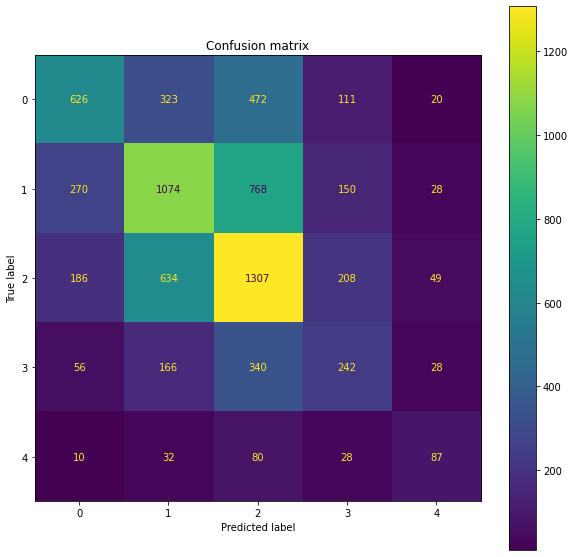

In [ ]:
cm = confusion_matrix(yTest, yPre)

plt.figure(figsize = (10, 10))
ax = plt.subplot(1, 1, 1)
disp = ConfusionMatrixDisplay(cm, display_labels = [0, 1, 2, 3, 4])
disp.plot(ax = ax)
plt.title('Confusion matrix')
plt.show()

In [ ]:
# Precision: score to measure ability not to label as positive a sample that is negative
print('Precision:', precision_score(yTest, yPre, average = 'micro'))
print('Precision:', precision_score(yTest, yPre, average = 'weighted'))

Precision: 0.4572995202193283
Precision: 0.46190359662682257


In [ ]:
# Recall: score to measure ability to find positive outcomes
print('Recall:', recall_score(yTest, yPre, average = 'micro'))
print('Recall:', recall_score(yTest, yPre, average = 'weighted'))

Recall: 0.4572995202193283
Recall: 0.4572995202193283


In [ ]:
# F1 score: mean of precision and recall
print('F1 score:', f1_score(yTest, yPre, average = 'micro'))
print('F1 score:', f1_score(yTest, yPre, average = 'weighted'))

F1 score: 0.4572995202193283
F1 score: 0.4552345263922959


#### Decision Trees

Use condiditional probabilities.

##### Tuning hyper-parameters

In [ ]:
# Take a small sample to avoid delays in tuning hyper-parameters
dataConfiguration.sampleSize = 0.2
(xTrain, yTrain), (xTest, yTest) = getData(dsTrainUseful, dataConfiguration)

dsTrain_ shape: (1459, 52)
dsTest_ shape: (365, 52)


In [ ]:
dtr = DecisionTreeClassifier()

In [ ]:
pca = PCA()

In [ ]:
parameters = {
    'pca__n_components': [5, 10, 15, 20, 25, 30],
    'pca__svd_solver': ['auto', 'full', 'arpack', 'randomized'],
    'trainer__criterion': ['gini', 'entropy'],
    'trainer__splitter': ['best', 'random']
}

pipeline = Pipeline(steps = [('pca', pca), ('trainer', dtr)])

In [ ]:
search = GridSearchCV(pipeline, parameters)
search.fit(xTrain, yTrain)

GridSearchCV(estimator=Pipeline(steps=[('pca', PCA()),
                                       ('trainer', DecisionTreeClassifier())]),
             param_grid={'pca__n_components': [5, 10, 15, 20, 25, 30],
                         'pca__svd_solver': ['auto', 'full', 'arpack',
                                             'randomized'],
                         'trainer__criterion': ['gini', 'entropy'],
                         'trainer__splitter': ['best', 'random']})

In [ ]:
print('Best score:', search.best_score_)
print('Best params:', search.best_params_)

Best score: 0.31662665348585417
Best params: {'pca__n_components': 10, 'pca__svd_solver': 'auto', 'trainer__criterion': 'gini', 'trainer__splitter': 'best'}


Select best parameters and train using the whole data.

In [ ]:
dataConfiguration.sampleSize = 0
(xTrain, yTrain), (xTest, yTest) = getData(dsTrainUseful, dataConfiguration)

dsTrain_ shape: (29178, 52)
dsTest_ shape: (7295, 52)


In [ ]:
t = time.time()
dtr = DecisionTreeClassifier(criterion = search.best_params_['trainer__criterion'], splitter = search.best_params_['trainer__splitter'])
pca = PCA(n_components = search.best_params_['pca__n_components'], svd_solver = search.best_params_['pca__svd_solver'])

pipeline = Pipeline(steps = [('pca', pca), ('trainer', dtr)])
pipeline.fit(xTrain, yTrain)

print('Duration minutes:', (time.time() - t)/60)

Duration minutes: 0.014589254061381023


In [ ]:
yPre = pipeline.predict(xTest)
print('Accuracy:', accuracy_score(yTest, yPre))

Accuracy: 0.37395476353666895


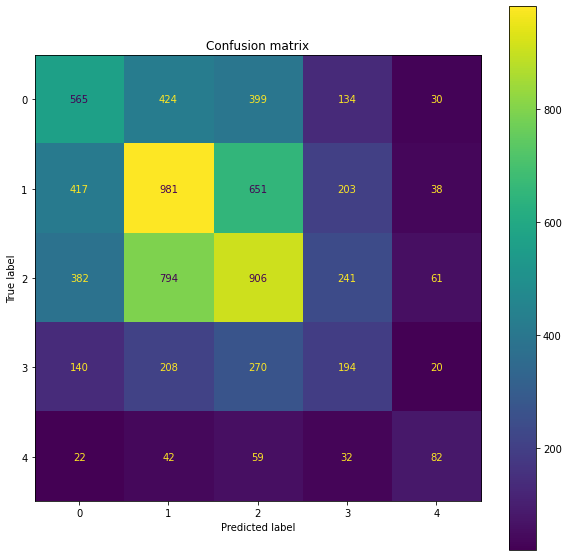

In [ ]:
cm = confusion_matrix(yTest, yPre)

plt.figure(figsize = (10, 10))
ax = plt.subplot(1, 1, 1)
disp = ConfusionMatrixDisplay(cm, display_labels = [0, 1, 2, 3, 4])
disp.plot(ax = ax)
plt.title('Confusion matrix')
plt.show()

In [ ]:
# Precision: score to measure ability not to label as positive a sample that is negative
print('Precision:', precision_score(yTest, yPre, average = 'micro'))
print('Precision:', precision_score(yTest, yPre, average = 'weighted'))

Precision: 0.37395476353666895
Precision: 0.37314257175060783


In [ ]:
# Recall: score to measure ability to find positive outcomes
print('Recall:', recall_score(yTest, yPre, average = 'micro'))
print('Recall:', recall_score(yTest, yPre, average = 'weighted'))

Recall: 0.37395476353666895
Recall: 0.37395476353666895


In [ ]:
# F1 score: mean of precision and recall
print('F1 score:', f1_score(yTest, yPre, average = 'micro'))
print('F1 score:', f1_score(yTest, yPre, average = 'weighted'))

F1 score: 0.3739547635366689
F1 score: 0.37332978570911407
